In [1]:
import numpy as np
import pickle
from cddm_data_simulation import ddm_simulate
import itertools as it

%matplotlib inline

In [6]:
# Load neural network
print("loading neural network model")
with open("dnn_weights.pickle", 'rb') as f:
    weights = pickle.load(f)

with open("dnn_biases.pickle", 'rb') as f:
    biases = pickle.load(f)

with open("dnn_activations.pickle", 'rb') as f:
    activations = pickle.load(f)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp((-1) * x))

def linear(x):
    return x

activation_fns = {
        "relu":relu,
        "sigmoid":sigmoid,
        "linear":linear
        }

def np_predict(x, weights, biases, activations):
    """
    Redefine the keras .predict function in numpy

    Params
    ------
    x: np.array((*batch_size, n_input))
        inputs to calculate the prediction for.
        batch size is optional
    weights: list of np.ndarray((n_input, n_hidden))
        list of the weight matrices for each layer
    biases: list of np.ndarray((n_hidden, ))
        list of the biases for each layer. Must be of
        same length as the weights list
    activations: list of strings
        list of the activations to apply for each layer
    """
    num_layers = len(weights)
    out = x
    for l in range(num_layers):
        out = np.dot(out, weights[l])
        out += biases[l]
        out = activation_fns[activations[l]](out)
    return out

def target(params, data):
    params_rep = np.tile(params, (data.shape[0], 1))
    input_batch = np.concatenate([params_rep, data], axis=1)
    out = np_predict(input_batch, weights, biases, activations)
    out[out <= 0] = 1e-28
    return np.log(out).sum()

loading neural network model


In [7]:
# simulate data
rts, choices, _ = ddm_simulate(n_samples=5000)
choices = choices * (-1)
data = np.concatenate([rts, choices], axis=1)

In [13]:
def create_param_grid(true_params, perturbation = .01, num_points=1000):
    grid = np.linspace((-1) * perturbation, perturbation, num_points)
    param_grid = grid[:, np.newaxis] + true_params
    return param_grid

In [19]:
true_params = np.array([0, 1, .5])
params_grid = create_param_grid(true_params, perturbation = .1)
out = [target(param, data) for param in params_grid]

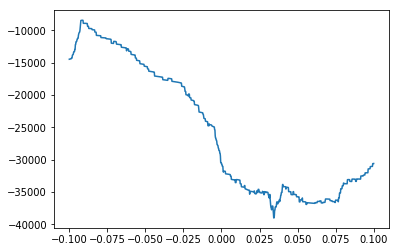

In [20]:
plt.plot(np.linspace(-.1, .1, 1000), out)

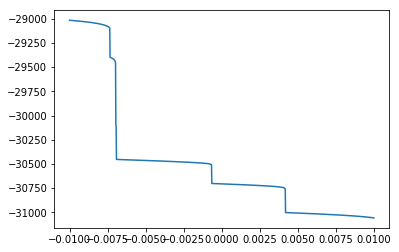

In [17]:
plt.plot(np.linspace(-.01, .01, 1000), out);

In [4]:
# Evaluate nn on grid of parameters
def create_grid(num_points=100):
    v_grid = np.linspace(-1, 1, num_points)
    a_grid = np.linspace(0, 1.5, num_points)
    w_grid = np.linspace(0, 1, num_points)
    
    out = list(it.product(v_grid, a_grid, w_grid))
    return out

In [11]:
grid = create_grid(num_points=10)

In [25]:
def evaluate_grid(grid, data):
    out = []
    for params in grid:
        params_rep = np.tile(np.array(params), (data.shape[0], 1))
        input_batch = np.concatenate([params_rep, data], axis=1)
        lp = np_predict(input_batch, weights, biases, activations)
        lp[lp <= 0] = 1e-28
        out.append(np.log(lp).sum())
    return out

In [27]:
out = evaluate_grid(grid, data)

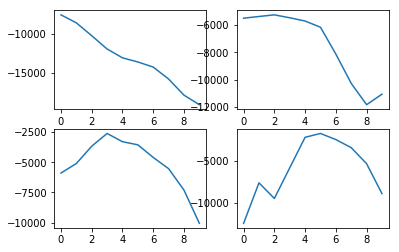

In [48]:
# Varying w, holding all other parameters constant
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
ax1.plot(out[0:10])
ax2.plot(out[10:20])
ax3.plot(out[20:30])
ax4.plot(out[30:40])